# [IAFlash](https://entrepreneur-interet-general.etalab.gouv.fr/defis/2019/iaflash.html) simple exploration

## Example of image clustering

Clusturing images may be useful to label a dataset of unlabel data: first cluster the data, then use the cluster as label. Optionally, find a small amount of label data to project onto the clusters, in order to infer the true of label corresponding to each cluster.  
We follow this [tutorial](https://www.pyimagesearch.com/2018/07/09/face-clustering-with-python/).

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/'))    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import os
import numpy as np
import re
import time
import pickle
from PIL import Image

from skimage.feature import daisy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

from IAFlash.basehelpers import pcaPlot, OneClassPerDirImageHandler

### Variables

In [2]:
# data
if HOST == 'Arthurs-MacBook-Pro.local':
#     pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwFalseresampleFilter0') # (small) MobileNet
#     pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwTrueresampleFilter0') # dummy model
    pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge299bwFalseresampleFilter0') # InceptionV3
    pathToIntellDir = os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/')
else:
    raise ValueError('unknown host: {}'.format(HOST))
data_format = 'channels_last'
nbClass = 196

dh = OneClassPerDirImageHandler(os.path.join(pathToDataDir,'Train'))

# image processing
edge = int(re.findall('edge([0-9]*)',pathToDataDir)[0])
if 'bwTrue' in pathToDataDir:
    mode = 'grayscale'
elif 'bwFalse' in pathToDataDir:
    mode = 'rgb'
else:
    raise ValueError('color mode not undestood from data directory name')
    


# seed
seed = 8
np.random.seed(seed)

### Intelligence

We use the [`ORB`](http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.ORB) feature detector and binary descriptor extractor from [scikit-image](https://scikit-image.org).  
NB: it seems that images must be not too small.  

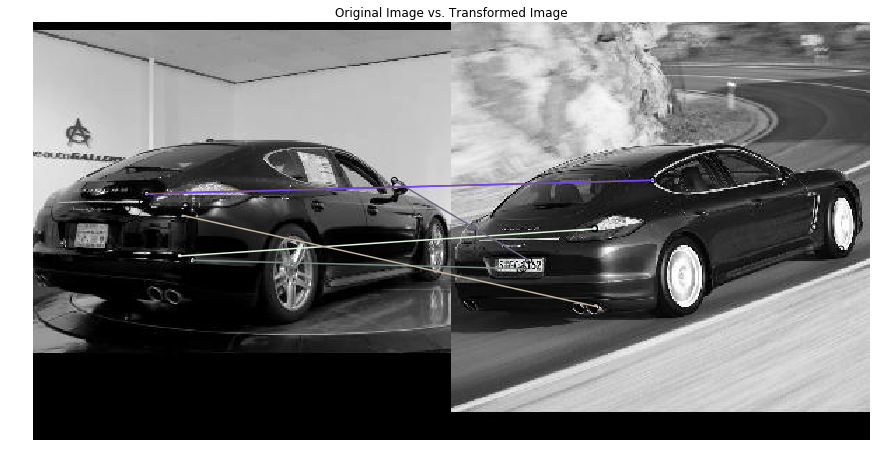

In [3]:
from skimage import data
from skimage import transform as tf
from skimage.feature import ORB, plot_matches, match_descriptors
import matplotlib.pyplot as plt

n_scales = 8
n_keypoints = 10
fast_n = int(16/2)
fast_threshold = 0.08 # decrease the threshold when more corners are desired and vice-versa
harris_k = 0.04 # small values of k result in detection of sharp corners


image_file1 = os.path.join(pathToDataDir, 'Test', 'Porsche Panamera Sedan 2012/014263.jpg')
image_file2 = os.path.join(pathToDataDir, 'Test', 'Porsche Panamera Sedan 2012/014262.jpg')

image1 = Image.open(image_file1)
image2 = Image.open(image_file2)


img1 = np.array(image1.convert('L'))
img2 = np.array(image2.convert('L'))


descriptor_extractor = ORB(n_keypoints=n_keypoints,
                           downscale=1.2,
                           n_scales=n_scales,
                           fast_n=fast_n,
                           fast_threshold=fast_threshold,
                           harris_k=harris_k)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

f = plt.figure(figsize = (15,10))
ax = f.add_subplot(1,1,1)

plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("Original Image vs. Transformed Image")

plt.show()

In [4]:
n_scales = 8
n_keypoints = 100
fast_n = int(16/2)
fast_threshold = 0.01 # 0.08 # decrease the threshold when more corners are desired and vice-versa
harris_k = 0.01 # 0.04 # small values of k result in detection of sharp corners

descriptor_extractor = ORB(n_keypoints=n_keypoints,
                           downscale=1.2,
                           n_scales=n_scales,
                           fast_n=fast_n,
                           fast_threshold=fast_threshold,
                           harris_k=harris_k)

In [5]:
# gather together all features from all images

tic = time.time()

ls_imgFeat = [] # list of feature arrays by image
ls_imgKeypatch = [] # list of list of keypatches by image
ls_y = []       # list of label by image

for c in (30,70):
    
    print(dh.classDict[c])
    ls_im = dh.getImage(c,[0,1,2,3,4])
    for im in ls_im:

        im = im.convert('L')
        x_im = np.array(im.convert('L'))

        descriptor_extractor.detect_and_extract(x_im)
        
        keypoints = descriptor_extractor.keypoints
        imgKeypatch = []
        for kx,ky in keypoints:
            imgKeypatch.append(im.crop(box=(int(kx-10),int(ky-10),int(kx+10),int(ky+10))))
        descriptor = descriptor_extractor.descriptors
        
#         display(im)
#         for kp in imgKeypatch:
#             display(kp)
        
        # store image-wise elements
        ls_imgKeypatch.append(imgKeypatch)
        ls_imgFeat.append(descriptor)
        ls_y.append(c)

# regroup all elements independently from images
allImgKeypatch = []
for kp in ls_imgKeypatch:
    allImgKeypatch += kp
allImgFeat = np.array(ls_imgFeat).reshape((len(ls_imgFeat)*n_keypoints,ls_imgFeat[0].shape[-1]))
y = np.array(ls_y)

print('done: took {}s'.format(np.round(time.time()-tic,2)))

Aston Martin Virage Convertible 2012
Ford F-150 Regular Cab 2012
done: took 1.6s


In [6]:
# look at the patches in a trash directory

for i,im in enumerate(allImgKeypatch):
    im.save('/Users/arthur/Desktop/dropit/'+str(i)+'.png')

In [7]:
# cluster the patches

from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn import metrics

# db = DBSCAN(eps=0.3,
#             min_samples=1,
#             metric=lambda x1,x2: np.mean(x1==x2),
#             metric_params=None,
#             algorithm='brute',
#             leaf_size=10, #30,
#             p=2,
#             n_jobs=1)

# db.fit(allImgFeat)
# n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
# print(n_clusters_)

n_clusters = 200
sc = SpectralClustering(n_clusters=n_clusters,
                        eigen_solver=None,
                        random_state=None,
                        n_init=10,
                        affinity=lambda x1,x2: np.mean(x1==x2),
                        n_neighbors=10,
                        eigen_tol=0.0,
                        assign_labels='discretize',
                        kernel_params=None,
                        n_jobs=None)
sc.fit(allImgFeat)

SpectralClustering(affinity=<function <lambda> at 0x10470f8c8>,
          assign_labels='discretize', coef0=1, degree=3, eigen_solver=None,
          eigen_tol=0.0, gamma=1.0, kernel_params=None, n_clusters=200,
          n_init=10, n_jobs=None, n_neighbors=10, random_state=None)

In [8]:
for lb in range(sc.n_clusters):
    print('------ cluster {} -------'.format(lb))
    toDisplay = np.where(sc.labels_ == lb)[0]
    for i in toDisplay:
        display(allImgKeypatch[i])

------ cluster 0 -------


------ cluster 1 -------


------ cluster 2 -------


------ cluster 3 -------


------ cluster 4 -------


------ cluster 5 -------


------ cluster 6 -------


------ cluster 7 -------


------ cluster 8 -------


------ cluster 9 -------


------ cluster 10 -------


------ cluster 11 -------


------ cluster 12 -------


------ cluster 13 -------


------ cluster 14 -------


------ cluster 15 -------


------ cluster 16 -------


------ cluster 17 -------


------ cluster 18 -------


------ cluster 19 -------


------ cluster 20 -------


------ cluster 21 -------


------ cluster 22 -------


------ cluster 23 -------


------ cluster 24 -------


------ cluster 25 -------


------ cluster 26 -------


------ cluster 27 -------


------ cluster 28 -------


------ cluster 29 -------


------ cluster 30 -------


------ cluster 31 -------


------ cluster 32 -------


------ cluster 33 -------


------ cluster 34 -------


------ cluster 35 -------


------ cluster 36 -------


------ cluster 37 -------


------ cluster 38 -------


------ cluster 39 -------


------ cluster 40 -------


------ cluster 41 -------


------ cluster 42 -------


------ cluster 43 -------


------ cluster 44 -------


------ cluster 45 -------


------ cluster 46 -------


------ cluster 47 -------


------ cluster 48 -------


------ cluster 49 -------


------ cluster 50 -------


------ cluster 51 -------


------ cluster 52 -------


------ cluster 53 -------


------ cluster 54 -------


------ cluster 55 -------


------ cluster 56 -------


------ cluster 57 -------


------ cluster 58 -------


------ cluster 59 -------


------ cluster 60 -------


------ cluster 61 -------


------ cluster 62 -------


------ cluster 63 -------


------ cluster 64 -------


------ cluster 65 -------


------ cluster 66 -------


------ cluster 67 -------


------ cluster 68 -------


------ cluster 69 -------


------ cluster 70 -------


------ cluster 71 -------


------ cluster 72 -------


------ cluster 73 -------


------ cluster 74 -------


------ cluster 75 -------


------ cluster 76 -------


------ cluster 77 -------


------ cluster 78 -------


------ cluster 79 -------


------ cluster 80 -------


------ cluster 81 -------


------ cluster 82 -------


------ cluster 83 -------


------ cluster 84 -------


------ cluster 85 -------


------ cluster 86 -------


------ cluster 87 -------


------ cluster 88 -------


------ cluster 89 -------


------ cluster 90 -------


------ cluster 91 -------


------ cluster 92 -------


------ cluster 93 -------


------ cluster 94 -------


------ cluster 95 -------


------ cluster 96 -------


------ cluster 97 -------


------ cluster 98 -------


------ cluster 99 -------


------ cluster 100 -------


------ cluster 101 -------


------ cluster 102 -------


------ cluster 103 -------


------ cluster 104 -------


------ cluster 105 -------


------ cluster 106 -------


------ cluster 107 -------
------ cluster 108 -------


------ cluster 109 -------


------ cluster 110 -------


------ cluster 111 -------


------ cluster 112 -------
------ cluster 113 -------


------ cluster 114 -------


------ cluster 115 -------


------ cluster 116 -------
------ cluster 117 -------


------ cluster 118 -------


------ cluster 119 -------


------ cluster 120 -------
------ cluster 121 -------
------ cluster 122 -------


------ cluster 123 -------


------ cluster 124 -------


------ cluster 125 -------


------ cluster 126 -------
------ cluster 127 -------
------ cluster 128 -------


------ cluster 129 -------
------ cluster 130 -------
------ cluster 131 -------


------ cluster 132 -------
------ cluster 133 -------


------ cluster 134 -------


------ cluster 135 -------
------ cluster 136 -------


------ cluster 137 -------
------ cluster 138 -------
------ cluster 139 -------
------ cluster 140 -------
------ cluster 141 -------


------ cluster 142 -------
------ cluster 143 -------


------ cluster 144 -------
------ cluster 145 -------


------ cluster 146 -------


------ cluster 147 -------
------ cluster 148 -------
------ cluster 149 -------
------ cluster 150 -------


------ cluster 151 -------


------ cluster 152 -------
------ cluster 153 -------


------ cluster 154 -------
------ cluster 155 -------


------ cluster 156 -------


------ cluster 157 -------


------ cluster 158 -------


------ cluster 159 -------


------ cluster 160 -------


------ cluster 161 -------


------ cluster 162 -------


------ cluster 163 -------
------ cluster 164 -------


------ cluster 165 -------
------ cluster 166 -------
------ cluster 167 -------


------ cluster 168 -------
------ cluster 169 -------


------ cluster 170 -------
------ cluster 171 -------


------ cluster 172 -------
------ cluster 173 -------


------ cluster 174 -------


------ cluster 175 -------


------ cluster 176 -------


------ cluster 177 -------


------ cluster 178 -------


------ cluster 179 -------


------ cluster 180 -------
------ cluster 181 -------
------ cluster 182 -------


------ cluster 183 -------
------ cluster 184 -------


------ cluster 185 -------


------ cluster 186 -------


------ cluster 187 -------
------ cluster 188 -------
------ cluster 189 -------
------ cluster 190 -------


------ cluster 191 -------
------ cluster 192 -------


------ cluster 193 -------


------ cluster 194 -------


------ cluster 195 -------


------ cluster 196 -------


------ cluster 197 -------


------ cluster 198 -------


------ cluster 199 -------


In [219]:
# search for clusters in the set of daisy features
# using KMeans
n_centroidFeatures = 10

tic = time.time()

kmeans = KMeans(n_clusters=n_centroidFeatures, random_state=seed)
kmeans.fit(allFeat)

print('done: took {}s'.format(np.round(time.time()-tic,2)))

done: took 1.82s


In [220]:
# (not really sensible here actually) validate graphically

pca = PCA(n_components=3,
          copy=True,
          iterated_power='auto', 
          random_state=seed,
          svd_solver='auto',
          tol=0.0,
          whiten=False)
allFeat_pc = pca.fit_transform(allFeat)
# allFeat_pc = pca.fit_transform(avgFeat)

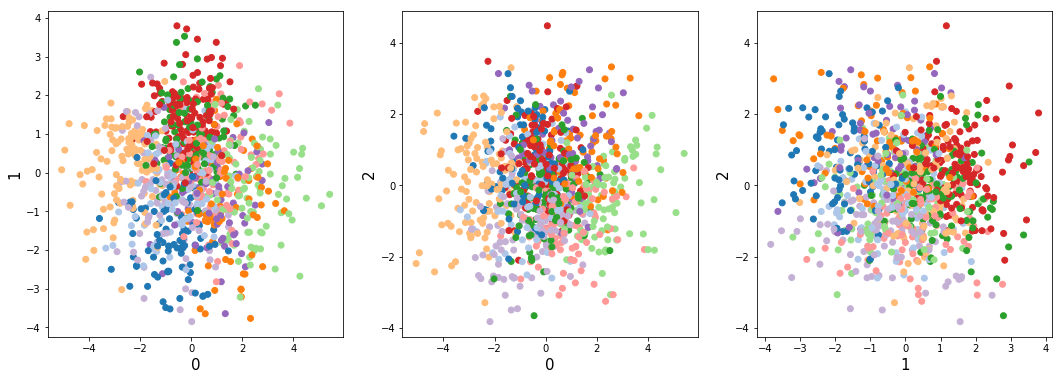

In [221]:
N = 1000
s = np.random.choice(allFeat_pc.shape[0],min(allFeat_pc.shape[0],N),replace=False)
pcaPlot(allFeat_pc[s,:], cm.tab20(kmeans.labels_[s]))

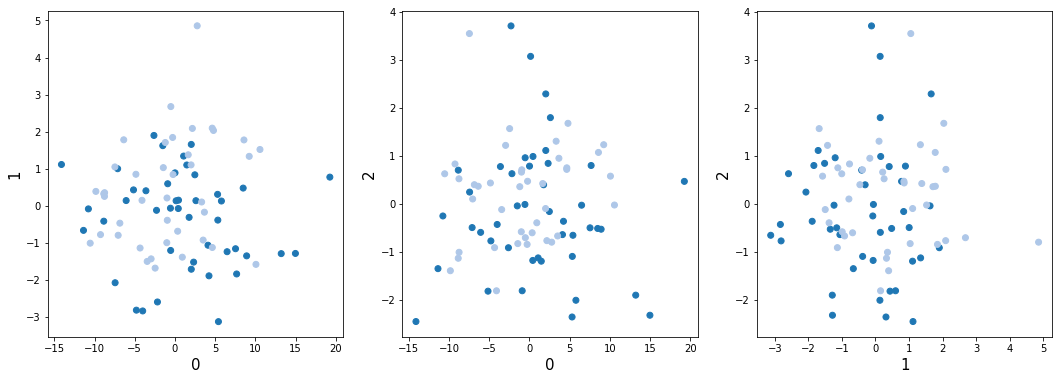

In [222]:
# given the 'centroid' features, now compute the bag-of-daisy vector for each image

centroidFeat = avgFeat.dot(kmeans.cluster_centers_.transpose())
# centroidFeat = centroidFeat / np.sqrt(np.sum(centroidFeat**2))

# validate graphically

pca = PCA(n_components=min(centroidFeat.shape[1],3),
          copy=True,
          iterated_power='auto', 
          random_state=seed,
          svd_solver='auto',
          tol=0.0,
          whiten=False)
centroidFeat_pc = pca.fit_transform(centroidFeat)

N = 1000
s = np.random.choice(allFeat.shape[0],N)
pcaPlot(centroidFeat_pc, cm.tab20(y))

Now let's test the [`daisy`](http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.daisy) descriptor.  
NB: it is not a feature extractor, that it, is does not describe 'keypoints' only, but rather all the image, as densely sampled according to parameters `step` and others.  

Pb: there may be a risk that the features described are not always insctructive!

In [9]:
Nkp = 7
rings = 2


step = int(edge/Nkp)
radius = int(step/max(1,rings))
histograms = 6
orientations = 6
visualize = False
normalization = 'l2' # L2-normalization of individual histograms
_R = (rings * histograms + 1) * orientations # number of features extracted (see docstring)
print(_R)

78


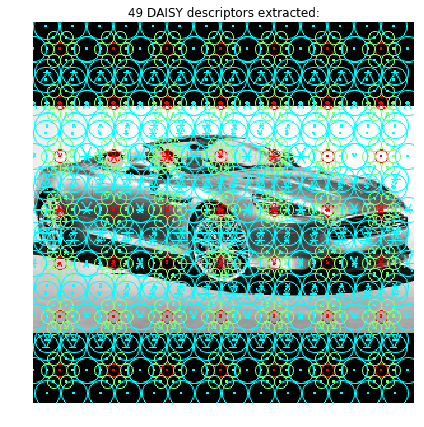

In [10]:
# try on one image
# CHECK:
# - regular spacing
# - no anomalies in gradients near edges

c,i = 30,0
image = dh.getImage(c,i)
img = np.array(image.convert('L'))

descs, descs_img = daisy(img,
                         step=step,
                         radius=radius,
                         rings=rings,
                         histograms=histograms,
                         orientations=orientations, 
                         visualize=True)


f = plt.figure(figsize = (7,7))
ax = f.add_subplot(1,1,1)

ax.axis('off')
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)

plt.show()

In [11]:
# gather together all features from all images

tic = time.time()

ls_imgFeat = [] # list of feature arrays by image
ls_imgKeypatch = [] # list of list of keypatches by image
ls_y = []       # list of label by image

for c in range(dh.nbClass):
# for c in (30,70):
# for c in (30,):
    print(dh.classDict[c])
    
    ls_im = dh.getImage(c,'all')
#     ls_im = dh.getImage(c,[0,1,2,3,4])
#     ls_im = dh.getImage(c,[0])

    for im in ls_im:

        im = im.convert('L')
        x_im = np.array(im.convert('L'))

        descs = daisy(x_im,
                      step=step,
                      radius=radius,
                      rings=rings,
                      histograms=histograms,
                      orientations=orientations, 
                      visualize=visualize,
                      normalization=normalization)
    
        imgKeypatch = [] # extract keypatches for verification: following formula ONLY WORKS if patches are well diposed
        for ky in range(Nkp):
            for kx in range(Nkp):
                imgKeypatch.append(im.crop(box=(int(step*kx),int(step*ky),int(step*(kx+1)),int(step*(ky+1)))))
        descriptor = descs.reshape(descs.shape[0]*descs.shape[1],descs.shape[2])
        
#         display(im)
#         for i,kp in enumerate(imgKeypatch):
#             display(kp)
#             print(descriptor[i,:])

        # store image-wise elements
        ls_imgKeypatch.append(imgKeypatch)
        ls_imgFeat.append(descriptor)
        ls_y.append(c)

# regroup all elements independently from images
allImgKeypatch = []
for kp in ls_imgKeypatch:
    allImgKeypatch += kp
allImgFeat = np.array(ls_imgFeat).reshape((len(ls_imgFeat)*Nkp**2,ls_imgFeat[0].shape[-1]))
y = np.array(ls_y)

print('done: took {}s'.format(np.round(time.time()-tic,2)))

Dodge Dakota Crew Cab 2010
GMC Canyon Extended Cab 2012
Hyundai Santa Fe SUV 2012
Dodge Durango SUV 2012
Chevrolet Silverado 1500 Extended Cab 2012
Ford Mustang Convertible 2007
Buick Rainier SUV 2007
Jeep Compass SUV 2012
Chevrolet Silverado 2500HD Regular Cab 2012
Ford Edge SUV 2012
Dodge Ram Pickup 3500 Quad Cab 2009
Bentley Continental Supersports Conv. Convertible 2012
Land Rover Range Rover SUV 2012
Hyundai Tucson SUV 2012
Honda Odyssey Minivan 2007
Audi 100 Wagon 1994
Dodge Challenger SRT8 2011
Mercedes-Benz Sprinter Van 2012
Bentley Continental GT Coupe 2012
Rolls-Royce Ghost Sedan 2012
Lamborghini Gallardo LP 570-4 Superleggera 2012
Dodge Charger SRT-8 2009
Volkswagen Beetle Hatchback 2012
Audi TT RS Coupe 2012
Acura TSX Sedan 2012
Jaguar XK XKR 2012
Aston Martin V8 Vantage Convertible 2012
Honda Accord Sedan 2012
BMW X5 SUV 2007
Ford F-150 Regular Cab 2007
Aston Martin Virage Convertible 2012
Chevrolet Silverado 1500 Regular Cab 2012
Chrysler 300 SRT-8 2010
FIAT 500 Convertib

In [67]:
# look at the patches in a trash directory

for i,im in enumerate(allImgKeypatch):
    im.save('/Users/arthur/Desktop/dropit/'+str(i)+'.png')

In [16]:
# cluster the patches


n_clusters = 100
cl = KMeans(n_clusters=n_clusters,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=0.0001,
            precompute_distances='auto',
            verbose=0, 
            random_state=seed,
            copy_x=True,
            n_jobs=1,
            algorithm='auto')
tic = time.time()
cl.fit(allImgFeat)
print('done: took {}s'.format(np.round(time.time()-tic,2)))

print(np.unique(cl.labels_, return_counts=True))


# cl = DBSCAN(eps=0.3,
#             min_samples=5,
#             metric='euclidean',
#             metric_params=None,
#             algorithm='auto',
#             leaf_size=10, #30,
#             p=2,
#             n_jobs=1)

# cl.fit(allImgFeat)
# n_clusters = len(set(cl.labels_)) - (1 if -1 in cl.labels_ else 0)
# print(np.unique(cl.labels_, return_counts=True))
# print(n_clusters)

done: took 2406.34s
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int32), array([ 6456,  8958,  2458,  2655,  3611,  3077,  2705, 10323,  2564,
        5603,  3138,  4584,  2451,  6533,  5120,  1620,  4840,  2381,
        5820,  2070,  3434,  1256,  8169,  3726,  2147,  3281,  4199,
        1767,  2446,  3459,  3899,  3362,  4655,  4444,  8584,  5013,
       14650,  1581,  3845,  2844,  1802,  1804, 10184,  4069,  5971,
        2856,  1704,  1332,  3548,  2385,  2072,  7168,  2563,  4604,
        5475,  4504,  7108,  2186,  2160,  3870,  1032,  5511,  1844,
        5623,  2005,  4313

------ cluster 0 -------


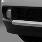

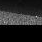

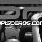

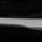

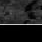

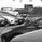

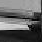

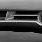

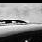

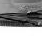

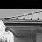

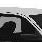

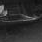

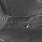

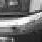

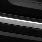

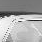

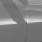

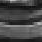

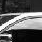

------ cluster 1 -------


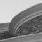

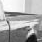

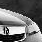

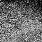

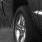

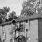

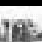

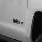

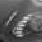

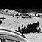

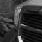

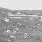

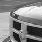

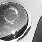

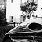

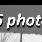

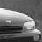

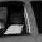

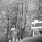

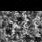

------ cluster 2 -------


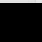

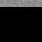

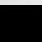

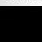

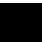

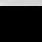

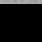

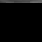

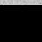

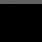

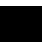

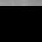

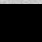

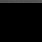

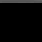

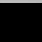

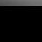

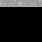

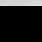

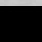

------ cluster 3 -------


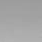

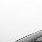

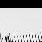

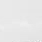

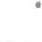

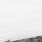

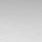

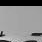

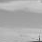

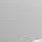

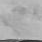

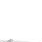

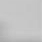

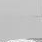

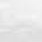

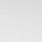

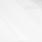

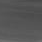

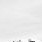

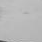

------ cluster 4 -------


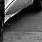

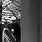

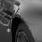

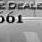

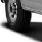

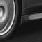

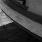

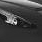

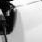

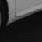

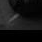

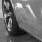

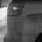

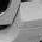

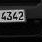

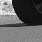

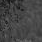

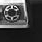

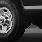

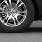

------ cluster 5 -------


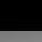

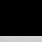

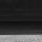

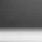

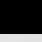

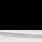

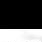

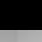

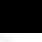

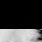

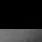

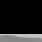

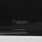

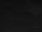

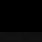

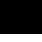

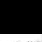

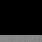

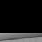

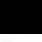

------ cluster 6 -------


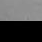

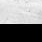

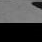

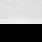

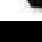

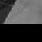

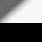

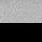

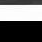

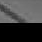

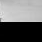

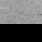

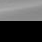

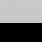

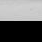

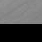

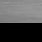

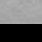

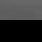

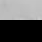

------ cluster 7 -------


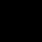

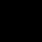

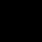

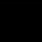

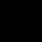

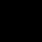

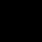

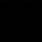

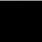

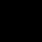

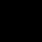

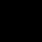

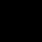

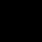

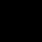

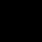

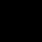

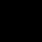

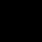

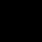

------ cluster 8 -------


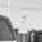

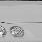

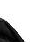

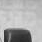

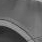

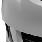

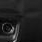

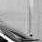

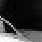

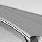

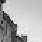

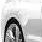

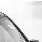

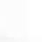

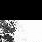

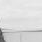

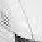

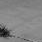

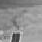

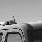

------ cluster 9 -------


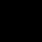

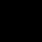

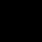

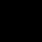

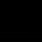

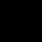

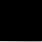

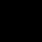

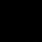

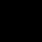

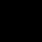

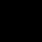

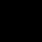

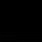

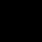

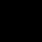

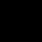

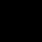

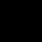

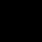

------ cluster 10 -------


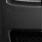

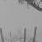

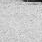

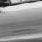

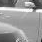

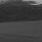

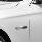

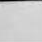

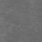

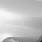

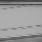

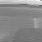

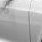

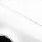

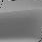

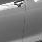

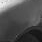

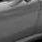

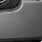

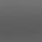

------ cluster 11 -------


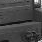

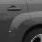

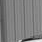

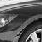

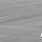

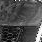

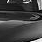

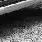

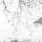

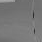

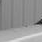

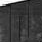

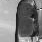

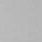

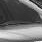

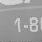

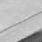

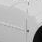

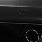

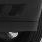

------ cluster 12 -------


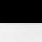

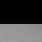

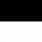

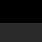

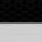

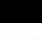

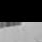

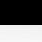

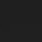

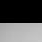

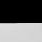

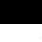

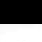

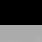

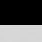

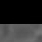

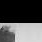

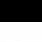

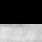

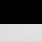

------ cluster 13 -------


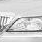

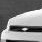

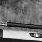

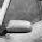

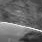

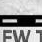

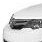

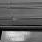

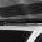

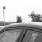

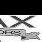

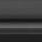

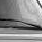

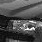

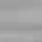

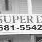

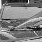

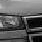

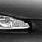

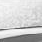

------ cluster 14 -------


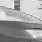

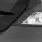

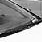

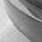

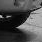

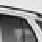

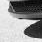

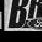

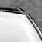

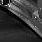

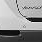

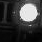

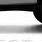

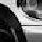

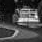

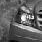

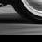

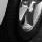

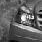

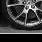

------ cluster 15 -------


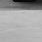

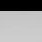

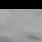

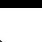

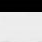

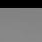

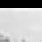

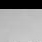

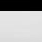

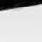

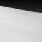

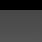

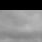

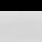

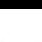

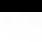

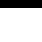

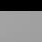

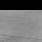

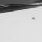

------ cluster 16 -------


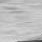

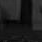

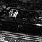

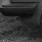

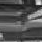

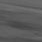

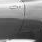

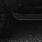

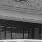

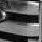

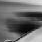

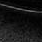

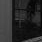

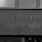

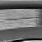

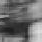

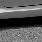

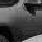

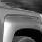

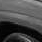

------ cluster 17 -------


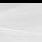

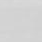

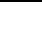

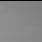

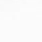

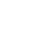

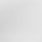

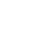

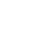

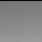

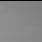

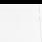

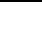

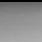

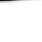

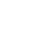

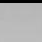

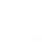

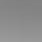

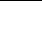

------ cluster 18 -------


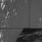

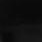

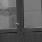

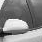

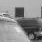

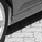

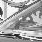

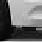

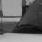

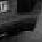

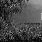

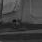

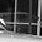

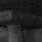

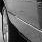

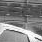

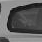

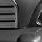

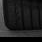

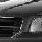

------ cluster 19 -------


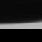

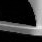

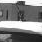

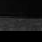

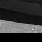

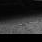

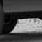

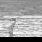

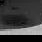

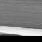

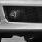

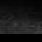

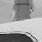

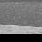

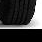

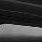

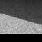

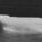

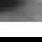

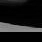

------ cluster 20 -------


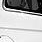

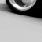

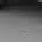

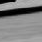

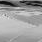

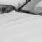

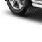

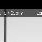

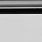

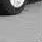

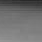

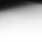

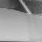

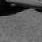

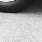

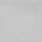

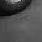

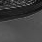

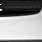

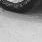

------ cluster 21 -------


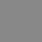

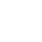

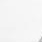

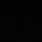

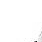

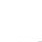

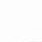

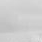

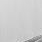

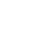

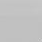

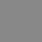

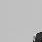

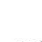

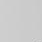

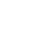

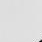

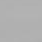

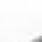

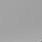

------ cluster 22 -------


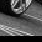

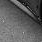

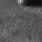

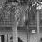

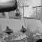

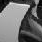

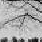

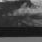

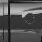

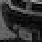

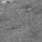

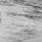

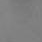

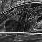

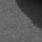

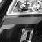

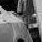

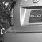

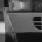

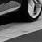

------ cluster 23 -------


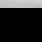

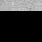

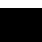

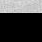

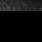

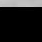

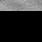

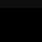

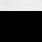

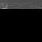

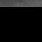

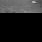

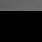

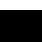

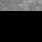

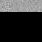

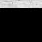

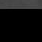

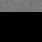

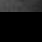

------ cluster 24 -------


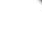

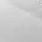

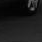

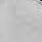

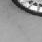

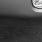

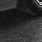

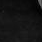

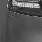

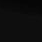

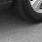

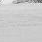

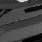

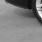

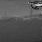

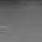

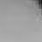

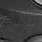

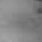

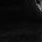

------ cluster 25 -------


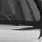

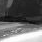

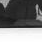

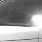

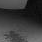

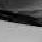

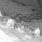

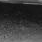

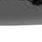

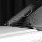

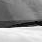

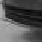

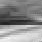

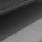

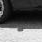

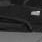

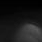

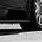

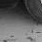

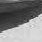

------ cluster 26 -------


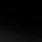

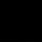

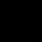

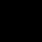

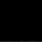

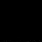

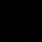

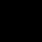

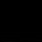

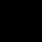

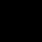

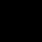

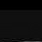

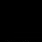

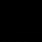

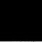

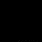

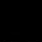

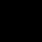

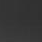

------ cluster 27 -------


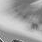

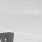

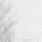

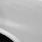

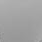

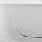

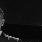

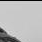

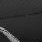

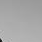

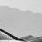

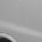

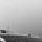

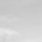

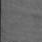

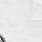

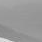

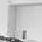

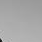

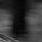

------ cluster 28 -------


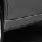

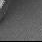

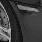

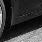

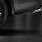

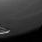

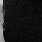

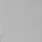

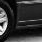

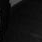

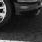

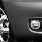

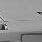

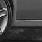

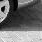

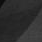

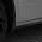

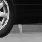

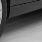

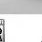

------ cluster 29 -------


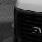

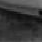

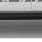

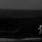

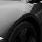

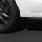

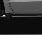

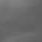

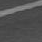

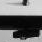

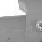

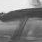

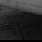

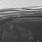

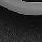

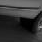

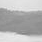

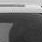

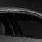

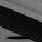

------ cluster 30 -------


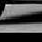

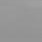

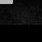

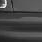

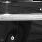

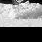

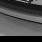

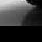

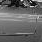

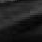

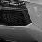

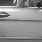

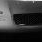

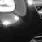

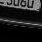

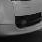

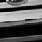

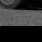

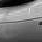

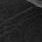

------ cluster 31 -------


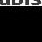

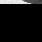

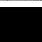

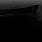

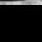

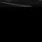

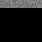

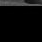

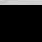

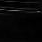

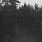

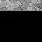

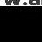

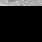

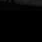

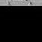

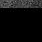

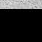

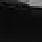

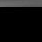

------ cluster 32 -------


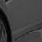

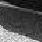

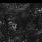

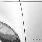

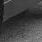

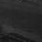

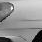

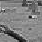

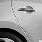

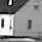

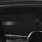

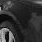

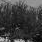

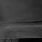

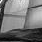

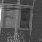

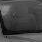

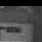

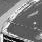

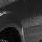

------ cluster 33 -------


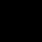

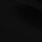

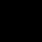

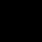

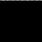

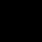

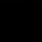

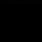

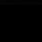

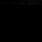

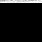

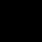

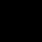

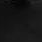

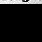

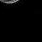

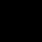

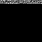

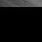

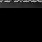

------ cluster 34 -------


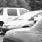

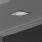

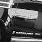

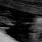

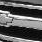

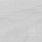

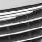

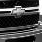

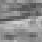

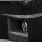

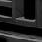

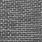

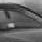

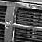

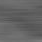

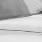

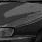

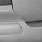

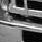

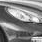

------ cluster 35 -------


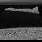

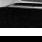

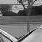

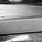

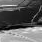

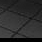

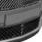

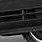

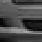

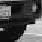

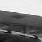

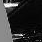

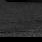

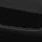

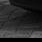

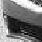

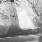

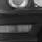

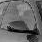

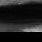

------ cluster 36 -------


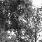

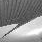

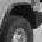

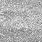

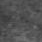

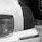

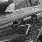

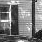

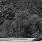

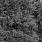

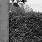

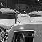

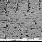

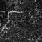

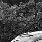

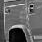

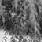

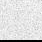

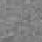

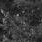

------ cluster 37 -------


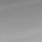

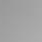

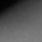

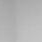

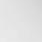

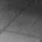

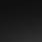

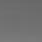

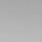

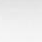

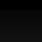

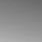

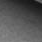

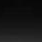

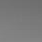

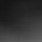

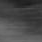

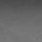

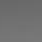

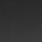

------ cluster 38 -------


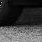

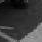

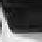

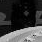

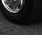

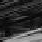

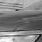

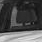

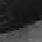

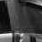

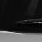

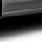

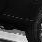

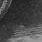

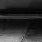

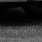

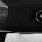

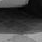

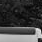

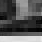

------ cluster 39 -------


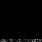

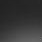

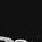

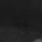

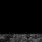

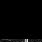

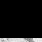

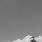

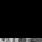

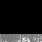

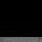

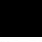

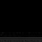

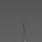

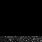

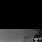

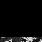

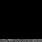

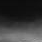

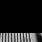

------ cluster 40 -------


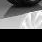

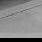

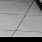

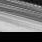

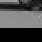

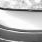

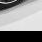

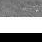

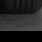

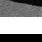

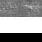

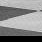

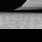

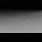

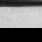

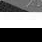

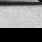

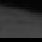

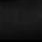

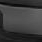

------ cluster 41 -------


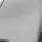

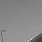

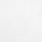

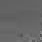

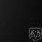

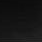

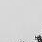

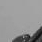

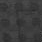

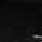

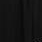

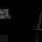

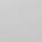

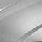

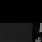

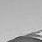

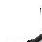

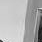

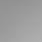

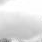

------ cluster 42 -------


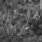

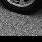

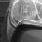

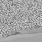

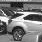

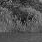

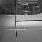

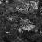

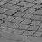

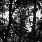

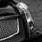

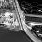

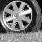

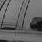

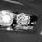

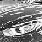

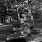

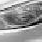

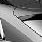

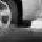

------ cluster 43 -------


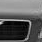

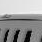

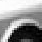

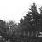

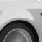

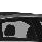

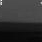

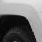

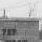

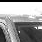

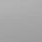

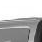

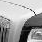

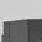

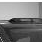

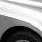

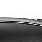

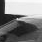

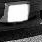

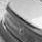

------ cluster 44 -------


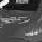

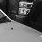

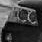

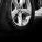

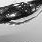

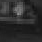

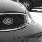

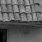

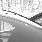

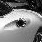

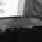

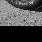

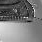

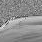

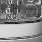

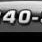

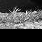

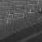

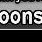

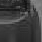

------ cluster 45 -------


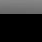

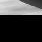

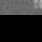

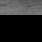

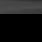

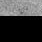

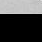

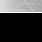

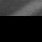

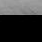

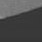

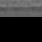

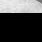

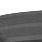

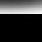

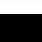

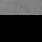

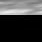

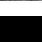

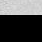

------ cluster 46 -------


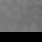

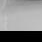

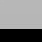

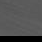

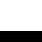

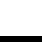

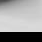

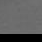

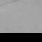

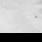

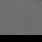

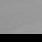

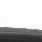

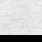

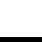

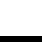

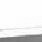

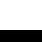

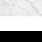

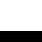

------ cluster 47 -------


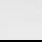

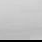

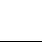

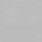

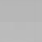

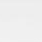

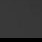

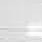

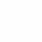

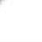

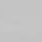

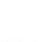

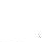

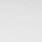

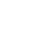

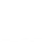

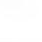

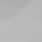

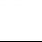

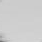

------ cluster 48 -------


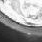

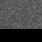

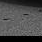

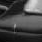

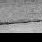

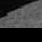

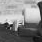

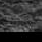

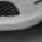

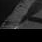

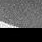

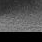

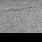

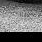

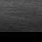

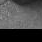

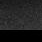

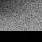

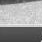

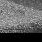

------ cluster 49 -------


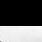

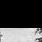

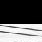

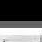

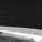

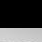

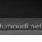

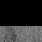

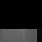

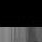

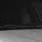

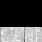

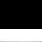

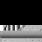

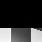

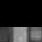

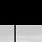

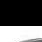

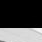

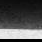

------ cluster 50 -------


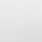

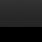

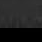

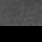

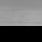

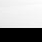

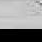

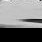

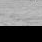

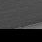

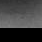

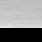

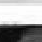

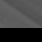

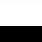

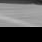

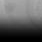

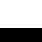

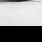

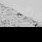

------ cluster 51 -------


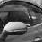

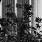

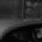

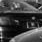

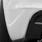

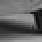

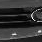

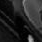

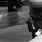

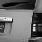

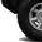

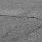

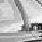

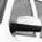

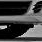

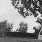

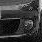

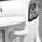

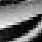

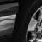

------ cluster 52 -------


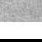

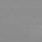

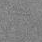

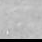

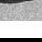

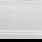

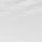

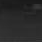

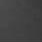

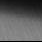

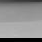

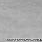

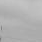

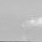

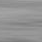

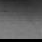

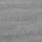

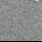

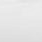

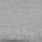

------ cluster 53 -------


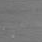

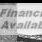

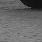

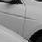

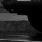

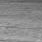

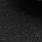

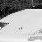

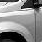

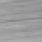

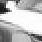

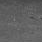

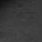

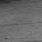

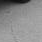

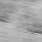

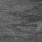

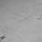

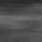

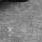

------ cluster 54 -------


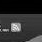

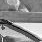

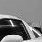

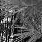

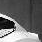

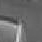

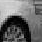

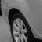

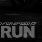

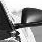

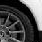

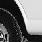

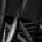

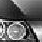

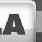

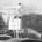

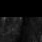

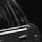

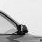

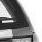

------ cluster 55 -------


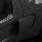

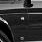

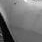

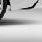

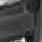

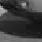

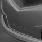

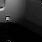

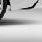

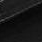

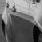

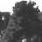

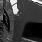

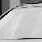

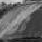

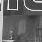

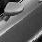

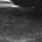

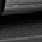

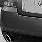

------ cluster 56 -------


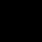

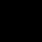

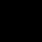

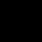

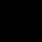

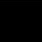

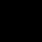

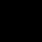

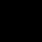

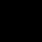

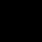

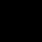

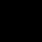

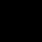

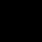

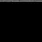

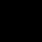

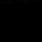

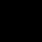

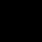

------ cluster 57 -------


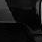

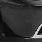

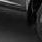

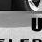

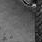

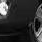

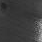

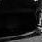

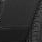

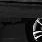

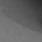

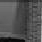

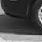

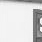

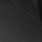

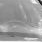

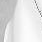

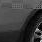

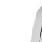

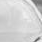

------ cluster 58 -------


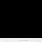

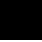

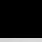

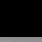

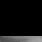

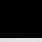

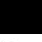

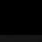

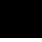

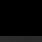

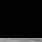

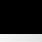

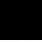

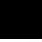

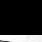

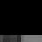

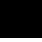

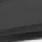

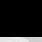

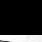

------ cluster 59 -------


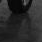

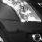

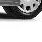

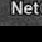

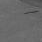

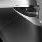

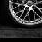

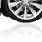

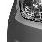

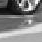

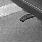

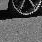

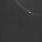

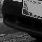

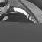

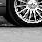

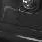

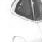

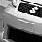

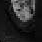

------ cluster 60 -------


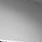

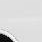

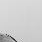

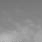

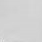

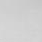

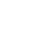

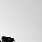

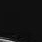

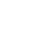

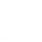

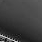

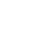

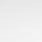

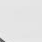

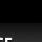

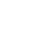

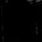

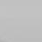

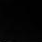

------ cluster 61 -------


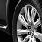

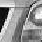

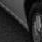

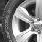

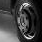

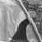

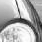

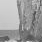

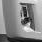

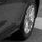

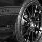

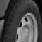

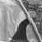

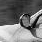

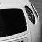

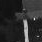

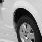

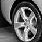

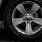

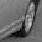

------ cluster 62 -------


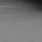

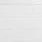

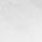

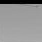

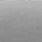

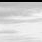

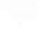

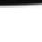

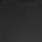

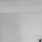

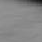

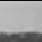

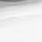

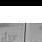

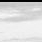

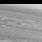

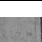

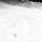

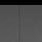

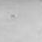

------ cluster 63 -------


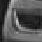

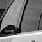

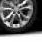

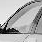

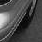

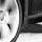

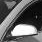

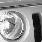

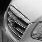

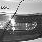

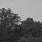

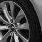

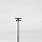

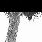

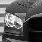

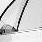

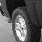

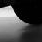

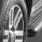

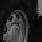

------ cluster 64 -------


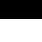

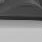

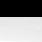

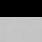

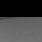

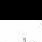

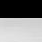

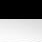

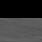

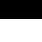

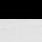

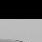

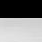

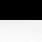

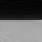

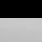

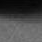

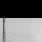

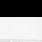

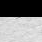

------ cluster 65 -------


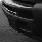

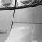

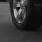

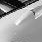

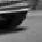

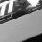

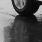

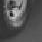

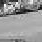

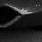

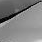

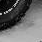

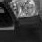

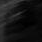

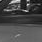

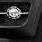

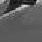

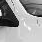

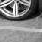

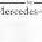

------ cluster 66 -------


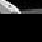

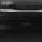

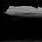

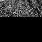

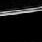

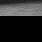

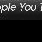

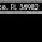

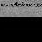

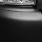

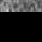

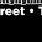

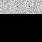

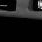

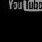

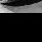

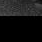

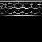

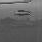

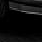

------ cluster 67 -------


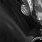

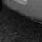

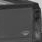

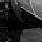

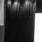

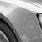

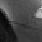

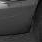

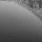

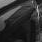

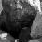

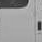

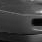

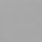

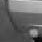

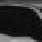

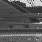

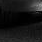

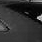

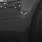

------ cluster 68 -------


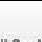

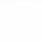

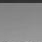

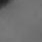

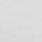

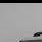

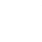

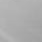

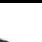

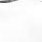

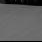

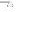

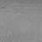

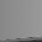

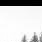

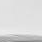

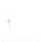

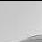

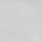

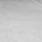

------ cluster 69 -------


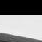

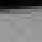

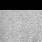

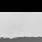

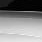

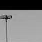

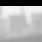

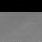

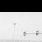

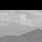

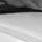

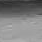

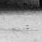

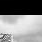

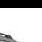

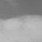

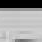

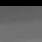

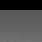

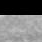

------ cluster 70 -------


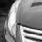

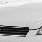

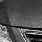

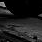

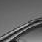

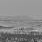

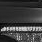

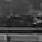

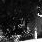

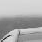

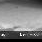

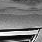

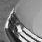

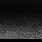

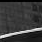

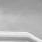

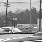

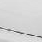

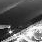

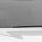

------ cluster 71 -------


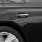

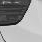

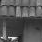

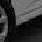

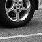

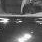

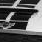

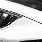

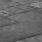

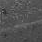

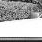

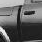

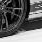

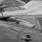

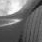

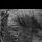

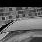

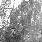

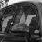

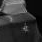

------ cluster 72 -------


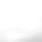

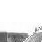

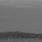

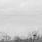

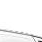

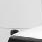

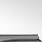

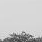

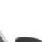

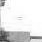

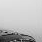

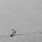

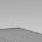

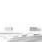

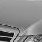

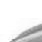

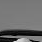

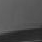

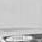

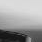

------ cluster 73 -------


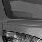

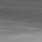

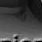

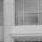

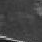

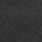

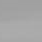

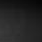

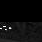

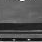

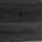

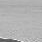

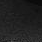

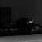

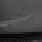

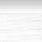

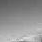

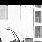

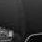

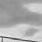

------ cluster 74 -------


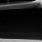

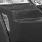

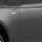

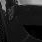

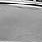

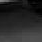

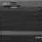

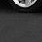

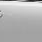

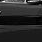

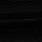

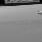

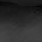

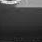

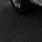

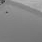

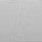

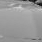

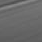

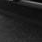

------ cluster 75 -------


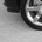

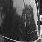

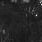

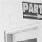

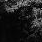

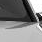

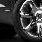

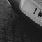

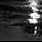

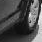

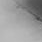

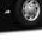

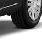

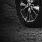

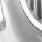

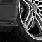

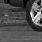

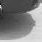

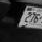

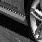

------ cluster 76 -------


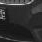

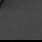

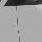

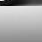

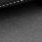

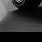

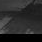

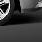

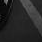

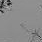

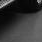

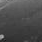

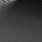

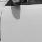

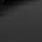

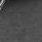

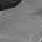

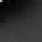

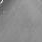

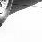

------ cluster 77 -------


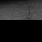

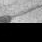

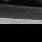

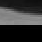

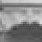

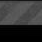

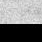

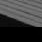

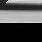

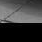

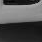

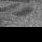

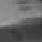

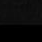

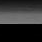

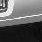

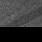

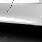

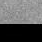

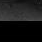

------ cluster 78 -------


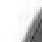

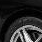

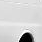

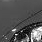

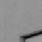

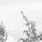

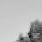

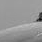

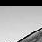

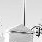

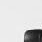

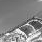

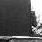

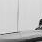

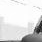

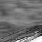

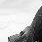

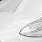

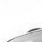

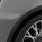

------ cluster 79 -------


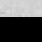

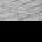

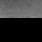

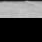

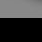

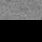

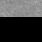

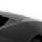

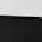

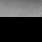

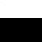

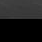

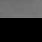

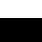

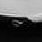

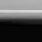

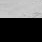

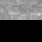

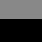

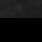

------ cluster 80 -------


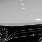

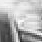

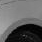

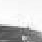

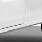

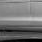

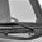

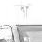

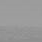

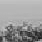

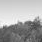

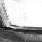

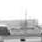

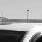

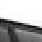

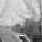

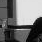

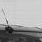

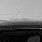

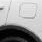

------ cluster 81 -------


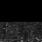

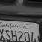

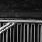

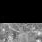

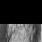

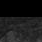

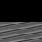

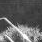

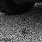

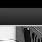

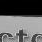

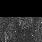

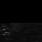

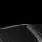

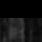

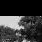

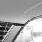

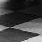

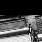

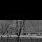

------ cluster 82 -------


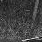

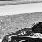

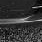

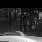

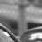

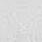

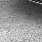

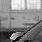

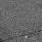

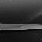

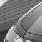

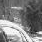

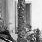

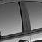

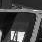

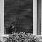

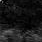

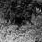

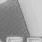

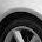

------ cluster 83 -------


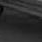

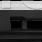

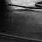

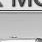

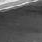

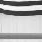

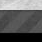

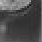

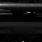

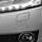

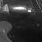

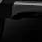

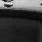

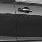

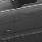

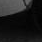

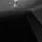

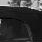

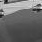

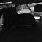

------ cluster 84 -------


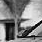

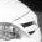

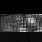

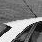

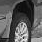

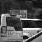

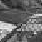

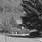

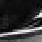

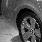

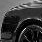

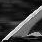

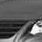

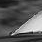

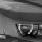

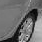

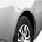

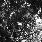

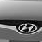

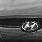

------ cluster 85 -------


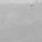

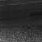

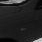

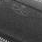

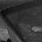

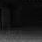

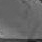

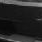

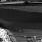

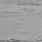

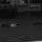

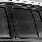

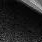

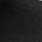

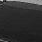

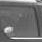

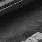

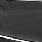

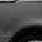

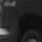

------ cluster 86 -------


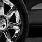

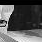

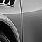

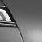

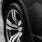

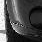

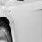

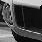

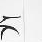

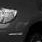

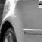

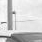

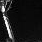

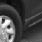

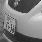

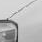

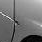

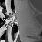

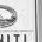

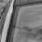

------ cluster 87 -------


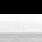

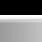

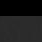

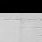

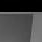

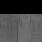

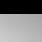

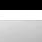

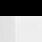

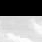

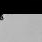

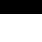

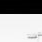

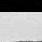

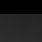

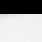

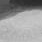

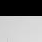

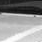

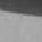

------ cluster 88 -------


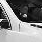

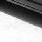

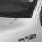

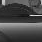

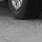

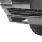

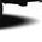

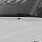

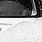

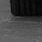

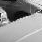

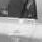

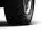

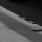

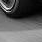

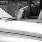

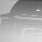

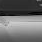

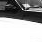

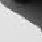

------ cluster 89 -------


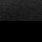

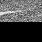

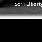

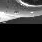

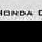

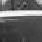

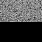

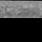

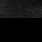

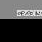

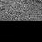

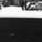

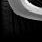

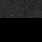

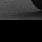

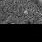

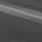

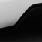

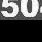

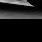

------ cluster 90 -------


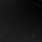

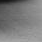

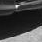

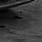

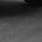

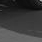

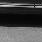

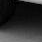

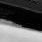

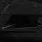

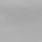

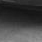

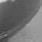

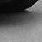

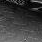

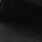

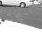

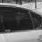

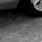

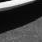

------ cluster 91 -------


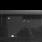

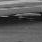

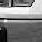

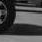

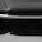

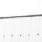

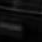

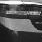

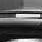

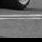

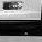

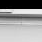

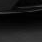

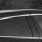

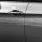

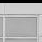

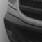

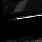

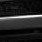

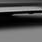

------ cluster 92 -------


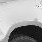

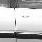

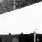

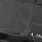

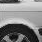

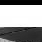

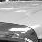

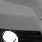

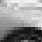

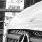

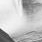

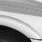

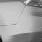

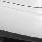

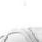

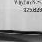

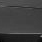

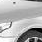

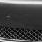

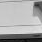

------ cluster 93 -------


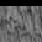

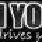

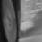

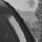

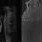

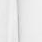

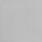

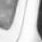

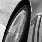

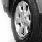

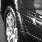

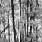

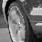

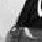

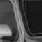

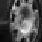

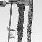

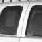

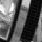

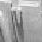

------ cluster 94 -------


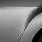

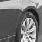

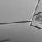

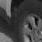

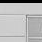

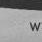

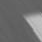

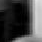

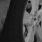

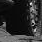

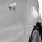

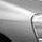

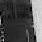

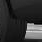

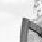

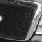

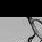

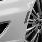

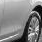

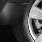

------ cluster 95 -------


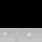

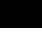

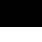

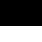

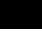

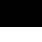

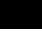

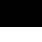

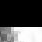

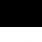

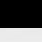

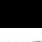

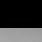

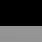

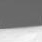

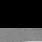

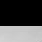

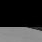

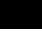

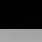

------ cluster 96 -------


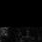

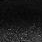

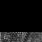

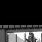

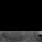

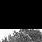

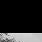

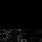

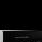

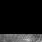

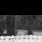

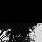

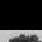

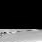

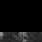

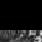

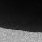

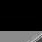

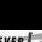

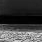

------ cluster 97 -------


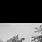

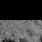

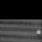

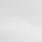

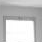

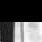

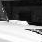

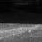

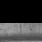

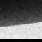

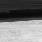

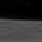

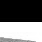

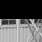

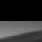

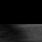

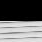

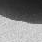

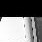

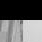

------ cluster 98 -------


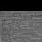

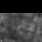

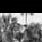

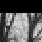

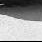

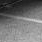

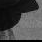

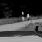

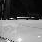

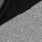

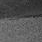

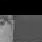

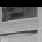

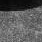

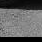

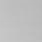

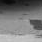

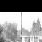

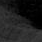

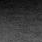

------ cluster 99 -------


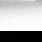

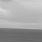

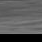

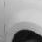

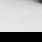

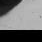

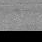

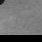

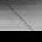

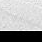

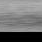

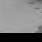

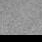

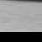

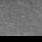

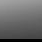

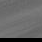

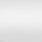

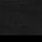

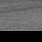

In [18]:
for lb in range(n_clusters):
    print('------ cluster {} -------'.format(lb))
    toDisplay = np.random.choice(np.where(cl.labels_ == lb)[0],20)
    for i in toDisplay:
        display(allImgKeypatch[i])

In [19]:
pickle.dump(y, open(os.path.join(pathToIntellDir, 'y.pkl'),'wb'))
pickle.dump(allImgFeat, open(os.path.join(pathToIntellDir, 'allImgFeat.pkl'),'wb'))
pickle.dump(allImgKeypatch, open(os.path.join(pathToIntellDir, 'allImgKeypatch.pkl'),'wb'))
pickle.dump(ls_imgFeat, open(os.path.join(pathToIntellDir, 'ls_imgFeat.pkl'),'wb'))

pickle.dump(cl, open(os.path.join(pathToIntellDir, 'kmeans.pkl'),'wb'))

In [229]:
# search for clusters in the set of daisy features
# using KMeans
n_centroidFeatures = 3

tic = time.time()

kmeans = KMeans(n_clusters=n_centroidFeatures, random_state=seed)
kmeans.fit(allFeat)

print('done: took {}s'.format(np.round(time.time()-tic,2)))

done: took 0.33s


In [230]:
# (not really sensible here actually) validate graphically

pca = PCA(n_components=3,
          copy=True,
          iterated_power='auto', 
          random_state=seed,
          svd_solver='auto',
          tol=0.0,
          whiten=False)
allFeat_pc = pca.fit_transform(allFeat)
# allFeat_pc = pca.fit_transform(avgFeat)

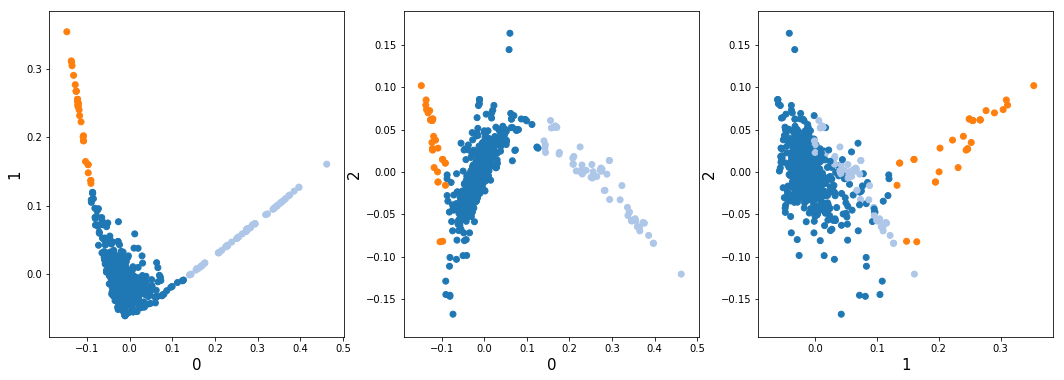

In [231]:
N = 1000
s = np.random.choice(allFeat_pc.shape[0],min(allFeat_pc.shape[0],N))
pcaPlot(allFeat_pc[s,:], cm.tab20(kmeans.labels_[s]))

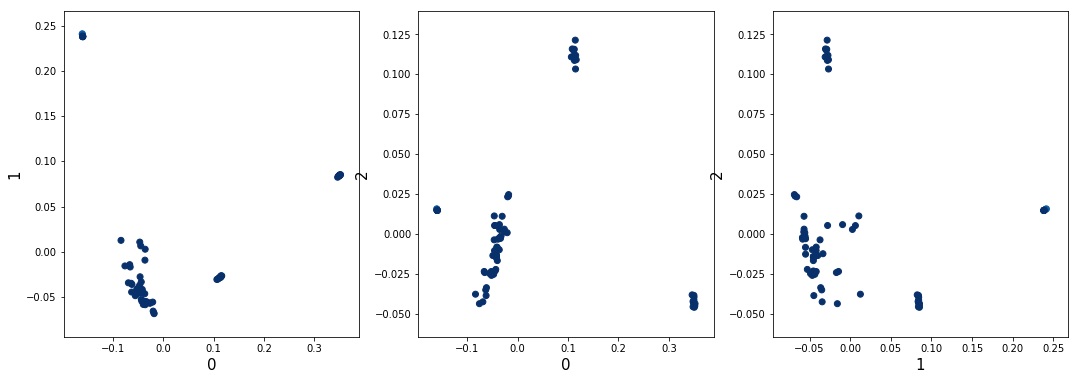

In [232]:
# (new try) validate graphically

pca = PCA(n_components=3,
          copy=True,
          iterated_power='auto', 
          random_state=seed,
          svd_solver='auto',
          tol=0.0,
          whiten=False)
allFeat_pc = pca.fit_transform(allFeat[:100,:])

pcaPlot(allFeat_pc, cm.Blues(np.arange(100)*10))

In [233]:
# given the 'centroid' features, now compute the bag-of-daisy vector for each image

centroidFeat = avgFeat.dot(kmeans.cluster_centers_.transpose())
# centroidFeat = centroidFeat / np.sqrt(np.sum(centroidFeat**2))

In [234]:
# validate graphically

pca = PCA(n_components=min(centroidFeat.shape[1],3),
          copy=True,
          iterated_power='auto', 
          random_state=seed,
          svd_solver='auto',
          tol=0.0,
          whiten=False)
centroidFeat_pc = pca.fit_transform(centroidFeat)

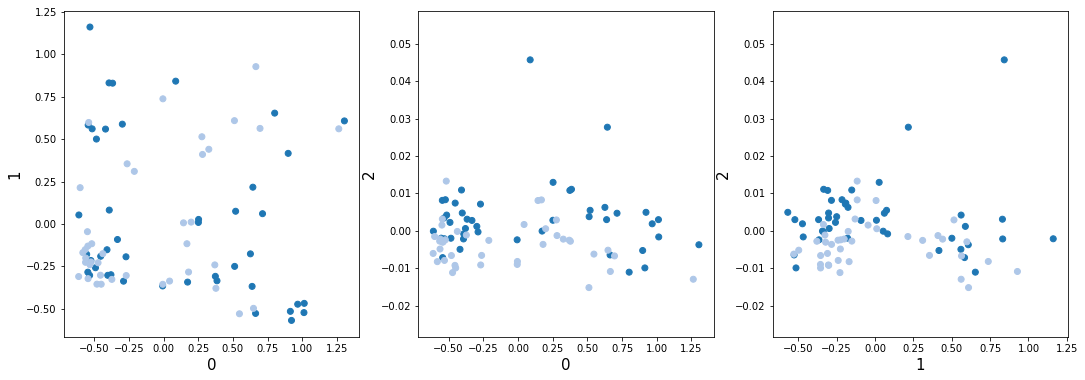

In [235]:
N = 1000
s = np.random.choice(allFeat.shape[0],N)
pcaPlot(centroidFeat_pc*100, cm.tab20(y))

In [98]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [115]:
avgFeat

array([[0.00686821, 0.00952877, 0.00794575, ..., 0.00841413, 0.01501285,
        0.01331584],
       [0.00640586, 0.01110444, 0.01055785, ..., 0.00802898, 0.01502264,
        0.01409506],
       [0.00812341, 0.00941261, 0.00854825, ..., 0.00915263, 0.01140838,
        0.00947862],
       ...,
       [0.00621504, 0.00990513, 0.00924636, ..., 0.01022563, 0.01157444,
        0.01031645],
       [0.00589347, 0.00833337, 0.00723012, ..., 0.01020299, 0.0127607 ,
        0.01087424],
       [0.00826784, 0.01051142, 0.00949274, ..., 0.00857602, 0.01083741,
        0.00979652]])

In [120]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])